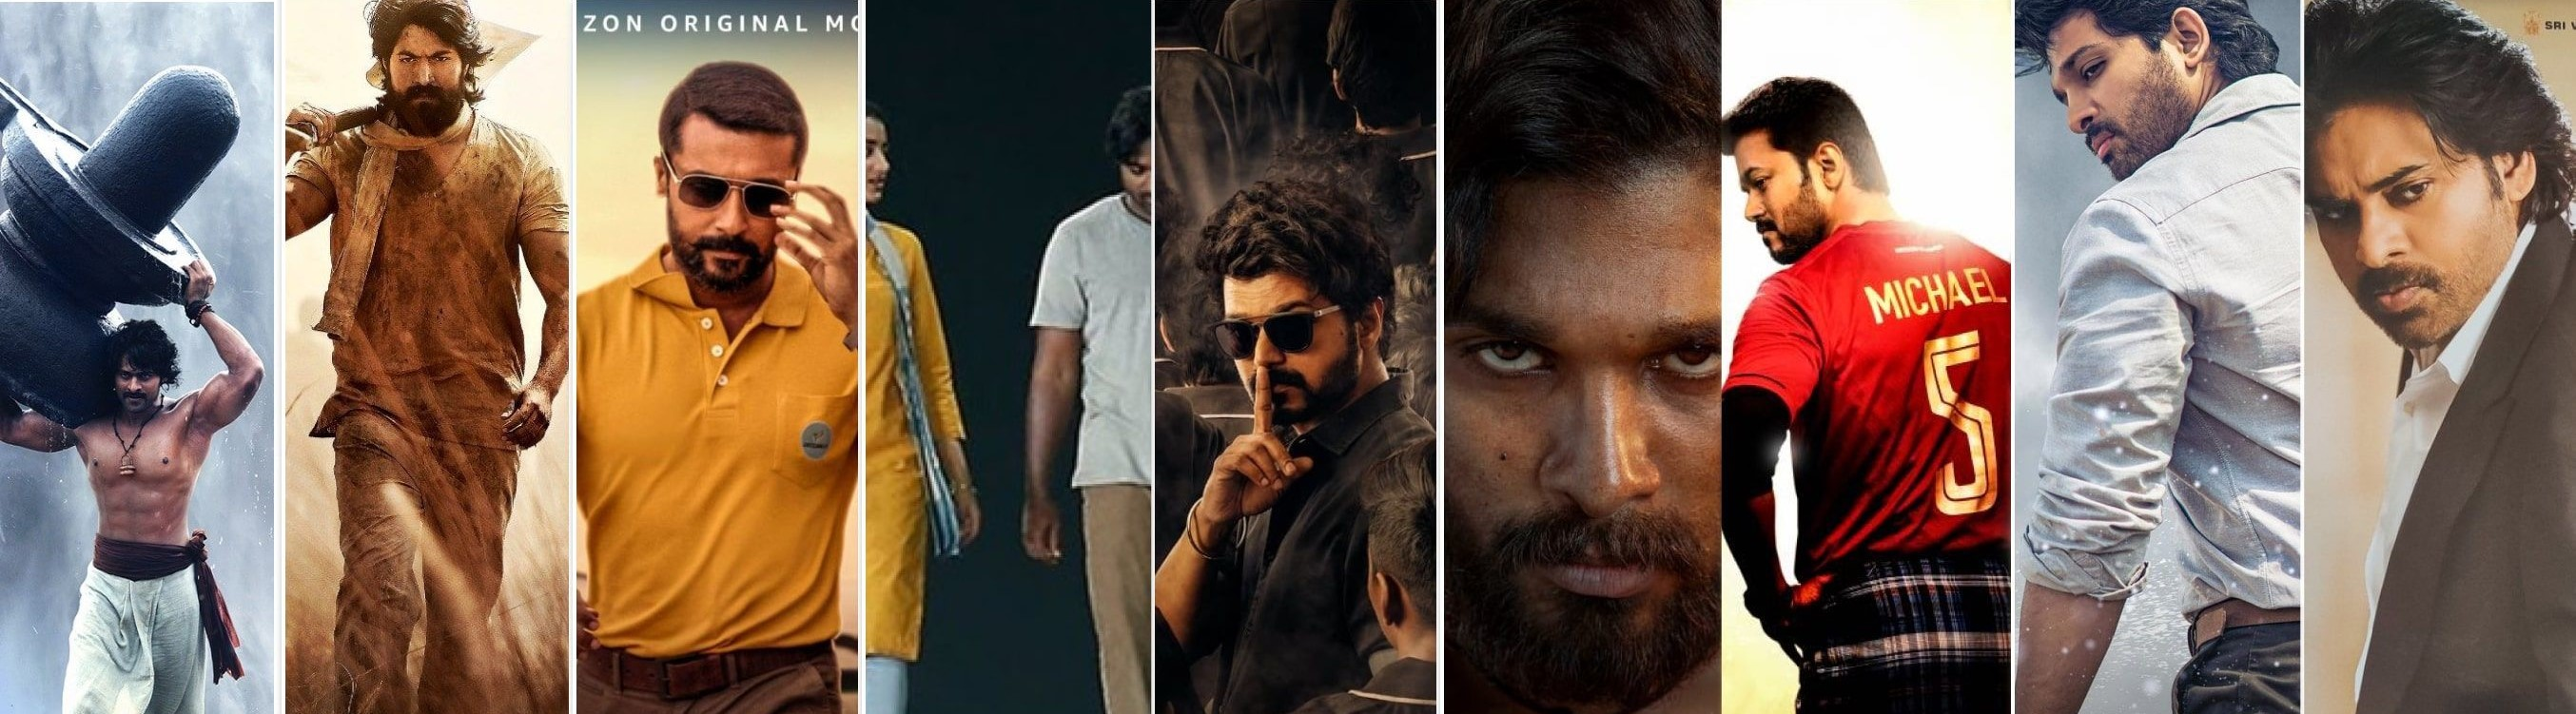

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#loading rating dataset
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
# loading movie dataset
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [5]:
user_freq = ratings[['userId', 'movieId']].groupby(
    'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head())

   userId  n_ratings
0       1        232
1       2         29
2       3         39
3       4        216
4       5         44


In [7]:
# Find Lowest and Highest rated movies:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
mean_rating.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [9]:
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
print(movies.loc[movies['movieId'] == lowest_rated])


      movieId         title   genres
2689     3604  Gypsy (1962)  Musical


In [10]:
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
print(movies.loc[movies['movieId'] == highest_rated])

    movieId            title           genres
48       53  Lamerica (1994)  Adventure|Drama


In [11]:
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [12]:
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [14]:
# the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
movie_stats.head(5)

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [15]:
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix

def create_matrix(df):

    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

In [17]:
#Find similar movies using KNN
from sklearn.neighbors import NearestNeighbors
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):

    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids


movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 3

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}")
for i in similar_ids:
    print("You should watch:",movie_titles[i])

Since you watched Grumpier Old Men (1995)
You should watch: Grumpy Old Men (1993)
You should watch: Striptease (1996)
You should watch: Nutty Professor, The (1996)
You should watch: Twister (1996)
You should watch: Father of the Bride Part II (1995)
You should watch: Broken Arrow (1996)
You should watch: Bio-Dome (1996)
You should watch: Truth About Cats & Dogs, The (1996)
You should watch: Sabrina (1995)
You should watch: Birdcage, The (1996)


In [18]:
def recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
    df1 = ratings[ratings['userId'] == user_id]

    if df1.empty:
        print(f"User with ID {user_id} does not exist.")
        return

    movie_id = df1[df1['rating'] == max(df1['rating'])]['movieId'].iloc[0]

    movie_titles = dict(zip(movies['movieId'], movies['title']))

    similar_ids = find_similar_movies(movie_id, X, k)
    movie_title = movie_titles.get(movie_id, "Movie not found")

    if movie_title == "Movie not found":
        print(f"Movie with ID {movie_id} not found.")
        return

    print(f"Since you watched {movie_title}, you might also like:")
    for i in similar_ids:
        print(movie_titles.get(i, "Movie not found"))

In [19]:
user_id = 145  # Replace with the desired user ID
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)

Since you watched Toy Story (1995), you might also like:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [20]:
user_id = 312  # Replace with the desired user ID
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)

Since you watched Taxi Driver (1976), you might also like:
Apocalypse Now (1979)
Fargo (1996)
Psycho (1960)
Rear Window (1954)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Reservoir Dogs (1992)
Vertigo (1958)
Chinatown (1974)
Godfather, The (1972)
Pulp Fiction (1994)
